<a href="https://colab.research.google.com/github/cl6530/DL_final_project/blob/main/training_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/cl6530/DL_final_project/main/env.py
!wget https://raw.githubusercontent.com/cl6530/DL_final_project/main/utils.py
!wget https://raw.githubusercontent.com/cl6530/DL_final_project/main/utils_wp.py
!wget https://raw.githubusercontent.com/cl6530/DL_final_project/main/dueling.py

--2023-05-05 19:30:40--  https://raw.githubusercontent.com/cl6530/DL_final_project/main/env.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2781 (2.7K) [text/plain]
Saving to: ‘env.py’

env.py              100%[===================>]   2.72K  --.-KB/s    in 0s      

2023-05-05 19:30:40 (44.3 MB/s) - ‘env.py’ saved [2781/2781]

--2023-05-05 19:30:41--  https://raw.githubusercontent.com/cl6530/DL_final_project/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3669 (3.6K) [text/plain]
Saving to: ‘utils.py’

utils.py   

# ENV

In [53]:
from env import StockTradingEnv
from utils import select_action,Transition,ReplayMemory, get_data #optimize_model
from utils_wp import optimize_model
from dueling import DuelingDQN
from google.colab import drive
import torch
import torch.nn as nn
import random
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Get Data

In [4]:
drive.mount('/content/drive')
path = r'/content/drive/My Drive/Colab Notebooks/dataset'
data = get_data(drive_path = path)

/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive
['/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2021.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2022.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2019.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2017.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2020.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2015.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2014.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2013.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2016.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2012.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2023.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2011.csv', '/content/drive/My Drive/Colab Notebooks/dataset/

In [54]:
import gym
import numpy as np
import pywt

class StockTradingEnv(gym.Env):
    '''
    Trading Simulator
    
    '''
    def __init__(self, stock_returns, transaction_cost, init_port):
        '''
        init methods, takes an array of returns as input
        '''
        super(StockTradingEnv, self).__init__()

        self.transaction_cost = transaction_cost
        self.init_port = init_port
        self.current_portfolio = init_port
        self.portfolio_history = [init_port, init_port]  # Add portfolio_history
        self.returns = stock_returns
        self.current_step = 4
        self.position = 0
        try:
          self.current_state = self._get_next_state()
        except:
          pass

        # Action space: {0: 'short', 1: 'stay', 2: 'long'}
        self.action_space = gym.spaces.Discrete(3)

        # State space: [1-day return, 5-day return]
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(2,), dtype=np.float32)


    def _get_next_state(self):
      '''
      using 1-day and 5-day return as the next state
      '''
      one_day_return = self.returns[self.current_step]
      five_day_return = self.returns[self.current_step - 4]
      return np.array([one_day_return, five_day_return])

    
    def _get_reward(self):
      '''
      #calculate reward
      #when posiiton is long, use 1 day return as reward
      #when position is short, use negative 1 day return as reward
      #FIXME: modify this function for experiment
      '''
      one_day_return = self.returns[self.current_step]
      if self.position == 1:
        return one_day_return
      elif self.position == -1:
        return -one_day_return
      else:
        return 0
    

    def step(self, action):
      ''' 
      step function
      1. change the position based on given action
      2. calculate next state
      3. get reward from state transition (one day return)
      4. return a transition tuple
      '''
      assert self.action_space.contains(action), f"{action} is an invalid action"

      # current state
      state = self.current_state

      # Calculate reward based on the chosen action

      # FIXED: Modify this part to add transcation cost
      # Calculate reward based on the chosen action
      #one_day_return = self.returns[self.current_step]
      if action == 0:  # short
          
          if self.position != -1:
             self.position = -1
             self.current_portfolio = (self.current_portfolio * (1 + self._get_reward())) * (1 - self.transaction_cost)
          else:
             self.current_portfolio = (self.current_portfolio * (1 + self._get_reward())) 

          self.portfolio_history.append(self.current_portfolio)  # Add current_portfolio to portfolio_history

      elif action == 1:  # stay
          if self.position != 0:
             self.position = 0
             self.current_portfolio = (self.current_portfolio * (1 + self._get_reward())) * (1 - self.transaction_cost)
          else:
             pass
          self.portfolio_history.append(self.current_portfolio)  # Add current_portfolio to portfolio_history

      elif action == 2:  # long
          if self.position != 1:
             self.position = 1
             self.current_portfolio = (self.current_portfolio * (1 + self._get_reward())) * (1 - self.transaction_cost)
          else:
             self.current_portfolio = (self.current_portfolio * (1 + self._get_reward())) 
          self.portfolio_history.append(self.current_portfolio)  # Add current_portfolio to portfolio_history
      
      # Calculate reward based on portfolio_history
      current_portfolio = self.current_portfolio
      previous_portfolio = self.portfolio_history[-2]
      reward = (current_portfolio - previous_portfolio) / previous_portfolio
      
      
      #next_state
      next_state = self._get_next_state()
      self.current_state = next_state

      # Update the current step
      self.current_step += 1

      #reward
      #reward = self._get_reward()

      # Check if the episode is done (reached the end of the stock prices data)
      done = self.current_step >= len(self.returns) - 1
      return state, action,reward,next_state, done

    def reset(self,stock_returns):
      '''
      reset the env with a new series of returns
      '''
      self.returns = stock_returns
      self.current_step = 5
      return self._get_next_state()


    def close(self):
      pass

# Models

In [76]:
EPS = 1
N_EXPLORATION = 20
TAU = 0.1
LR = 1e-3
TRANSCATION_COST = 0.0
INIT_PORT = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [77]:
policy_net = DuelingDQN(2, 3).to(device)
target_net = DuelingDQN(2, 3).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

In [78]:
def eval_model(policy):
    '''
    evaluate the model using test data (last 500 data points)
    and record the percentage of each action (long, short or stay)
    '''

    NAV = [1000]
    BAH = [1000]
    returns = data.values[-500:]
    env = StockTradingEnv(returns,TRANSCATION_COST,INIT_PORT)
    t = 5
    done = False
    actions = []
    while not done:
      state = env.current_state
      action = select_action(state,0,env.action_space,policy,device)
      actions.append(action.cpu())
      state, action,reward,next_state, done = env.step(action.item())
      NAV.append(NAV[-1]*(1+reward))
      BAH.append(BAH[-1]*(1+returns[t]))
      t+=1
    plt.plot(NAV, label = 'NAV')
    plt.plot(BAH, label = 'BAH')
    plt.legend()
    plt.show()
    plt.scatter(np.arange(0,len(actions)),actions,s=0.1)
    plt.show()

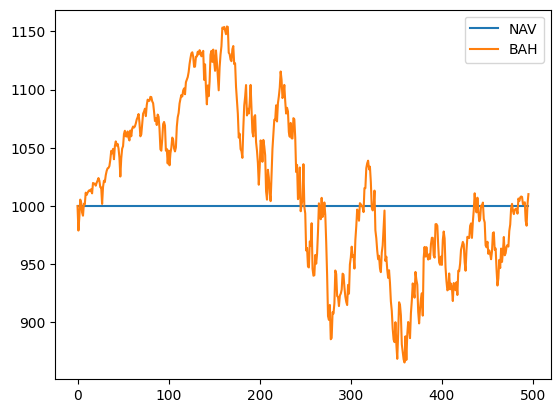

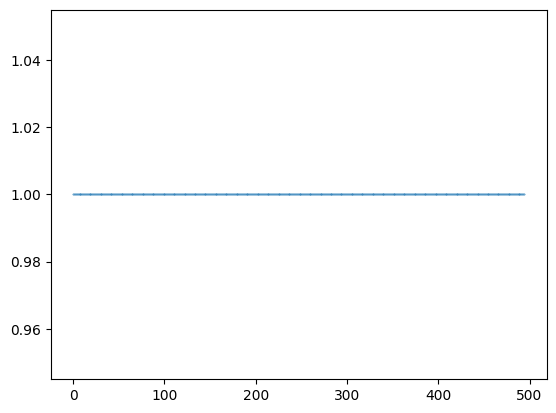

In [79]:
eval_model(target_net)

# Train

In [80]:
criterion = nn.MSELoss()

1


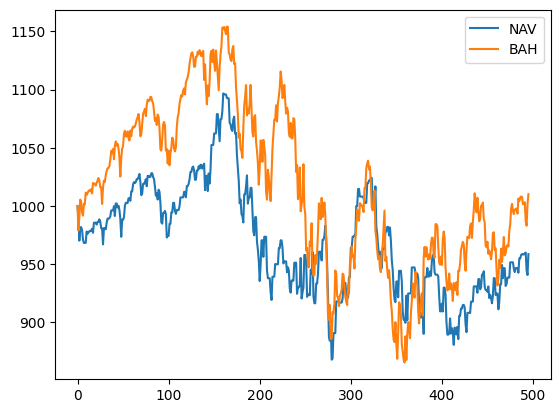

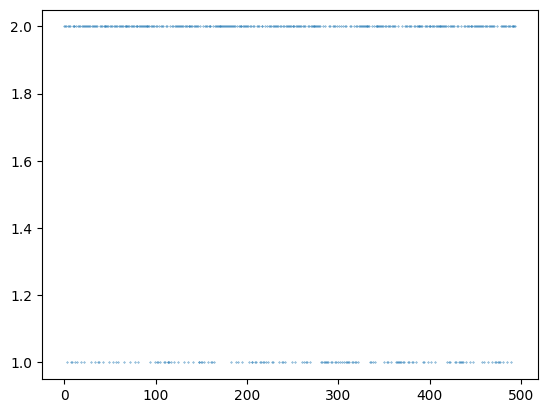

0.9500000000000002
0.9000000000000004
0.8500000000000005
0.8000000000000007
0.7500000000000009
0.7000000000000011
0.6500000000000012
0.6000000000000014
0.5500000000000016
0.5000000000000018


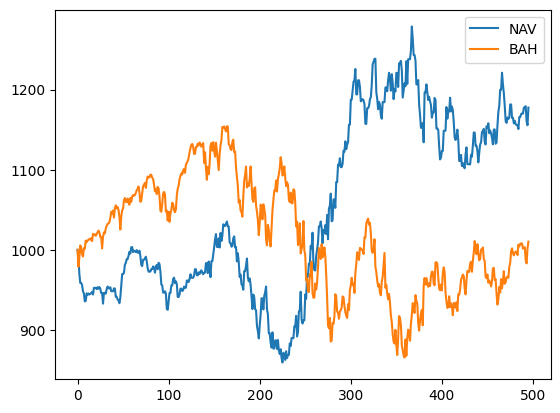

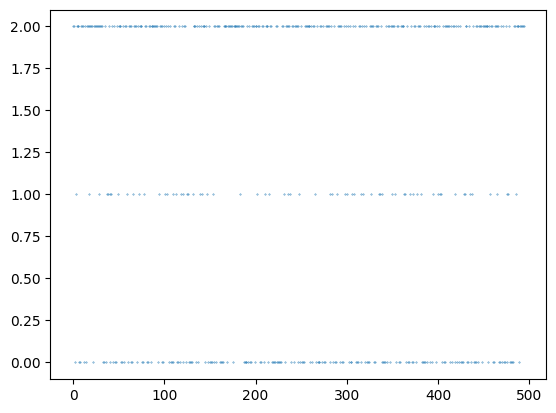

0.45000000000000195
0.40000000000000213
0.3500000000000023
0.3000000000000025
0.25000000000000266
0.20000000000000284
0.15000000000000302
0.1000000000000032
0.050000000000003375


KeyboardInterrupt: ignored

In [81]:
memory = ReplayMemory(100000)

if torch.cuda.is_available():
    num_episodes = 100
else:
    num_episodes = 50

for i_episode in range(num_episodes):

    # get 252 returns
    # since step start at 5, we extract 257 returns
    start = random.randint(0,len(data-500)-257)
    stock_returns = data.values[start:start + 257]

    #creat an env
    env = StockTradingEnv(stock_returns,TRANSCATION_COST,INIT_PORT)
    done = False
    print(EPS)
    while not done:    
      #linear epsilon decay in the first n_exploration episodes, then exploit
      EPS = max(0,EPS-1/(252*N_EXPLORATION))
      
      state = env.current_state

      #get action
      action = select_action(state,EPS,env.action_space,policy_net,device)

      #step
      state, action,reward,next_state, done = env.step(action.item())

      #store in replay
      memory.push(torch.tensor(state.astype(np.float32),device=device), torch.tensor([action],device=device), torch.tensor(next_state.astype(np.float32),device=device), torch.tensor(reward,device=device))

      #optimize
      if len(memory) < 2:
          continue
      if EPS > 0:
        optimize_model(memory,optimizer,policy_net,target_net,device,criterion,0,1)
      else:
        optimize_model(memory,optimizer,policy_net,target_net,device,criterion,-0.01,1.5)

      # FIXME: Current Verision using soft update, the paper uses hard updates every 100 step
      target_net_state_dict = target_net.state_dict()
      policy_net_state_dict = policy_net.state_dict()
      for key in policy_net_state_dict:
          target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
      target_net.load_state_dict(target_net_state_dict)
    if i_episode%10 == 0:
      eval_model(target_net)
eval_model(target_net)